# Code Challenge - Autoencoder - How many units

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

dataT = torch.tensor(dataNorm).float()

In [19]:
def createMNISTAE(enc, bn):
    
    class AENet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, enc) # input layer
            self.enc = nn.Linear(enc, bn) # encoder layer
            self.lat = nn.Linear(bn, enc) # latent layer
            self.dec = nn.Linear(enc, 784) # decoder layer - op is same as ip
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            return torch.sigmoid(self.dec(x)) # as ip data is in 0-1, op should be in same numerical range as ip
            
    net = AENet()
    
    lossfn = nn.MSELoss()
    optim = torch.optim.Adam(net.parameters(), lr=.001)
    
    return net, lossfn, optim

In [51]:
def trainModel(enc, bn):
    nEp = 3

    net, lossfn, optim = createMNISTAE(enc, bn)
    losses = []
    
    bs = 32 # batch size
    numBatches = int(dataT.shape[0]/bs)

    for i in range(nEp):
        randIdx = np.random.permutation(dataT.shape[0]).astype(int) # slecting a random set of images
        
        batchLosses = []
        
        for bi in range(numBatches):
            
            # non-overlapping samples to use in this batch
            samps2use = range((bi-1)*bs,bi*bs)
            
            X = dataT[randIdx[samps2use], :]
            
            
            # forward pass
            yH = net(X)
            loss = lossfn(yH, X) # data itself is a label

            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLosses.append(loss.item())

        losses.append(np.mean(batchLosses[-3:]))

    return losses, net

In [53]:
# Parametric Exp

enc = np.linspace(10, 500, 12).astype(int) # encoding-decoding units
bn = np.linspace(5, 100, 8).astype(int) # bottleneck units
lossRes = np.zeros((len(enc), len(bn)))
for i, e in enumerate(enc):
    for j, b in enumerate(bn):
        losses, net = trainModel(e, b)
        lossRes[i, j] = np.mean(losses[-1])
        
        # status updation
        currIter = i*len(bn) + j + 1
        totalIter = len(bn)*len(enc)
        msg = "Finished experiment {}/{}".format(currIter, totalIter)
        sys.stdout.write('\r' + msg) # \r - go in reverse (delete entire line and go back to beginning of line)

Finished experiment 96/96

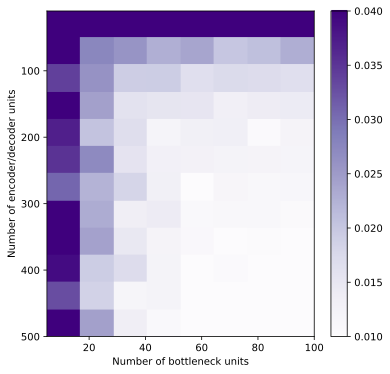

In [54]:
# show the results matrix
fig = plt.figure(figsize=(6,6))

plt.imshow(lossRes,aspect='auto',         # data and aspect ratio
           vmin=.01,vmax=.04, cmap='Purples', # color range and palette
           extent=[ bn[0],bn[-1],enc[-1],enc[0], ]) # xy axis ticks
           

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()

plt.show()

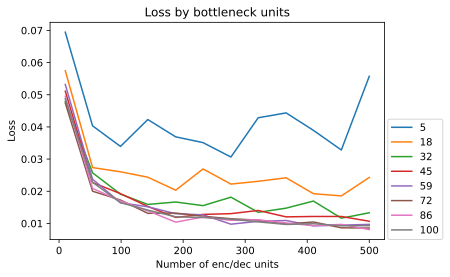

In [55]:
# perhaps a line plot will better reveal the sudden transition

plt.plot(enc,lossRes)
plt.legend(bn,loc=(1.01,0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()

# Code Challenge - Implementation on GPU

Change below code to work on GPU, and get data back to CPU whenever required

In [12]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import dataset (comes with colab!)
data = np.loadtxt(open('../data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Create train/test groups using DataLoader

# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

/tmp/ipykernel_7475/4236952429.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [13]:
# Create the DL model

# create a class for the model
def createTheMNISTNet(nUnits,nLayers):

  class mnistNet(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(784,nUnits)
      
      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,10)
    


    # forward pass
    def forward(self,x):
      # input layer (note: the code in the video omits the relu after this layer)
      x = F.relu( self.layers['input'](x) )

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )
      
      # return output layer
      x = self.layers['output'](x)
      return x
  
  # create the model instance
  net = mnistNet(nUnits,nLayers)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [14]:
# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer,nLayers)
net

# Create a function that trains the model

# a function that trains the model

def funtion2trainTheModel(nUnits,nLayers):

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

  net.to(device)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      
      yHat = yHat.cpu()
      y = y.cpu()
      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct.cpu() )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    yHat = yHat.cpu()
    y = y.cpu()
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


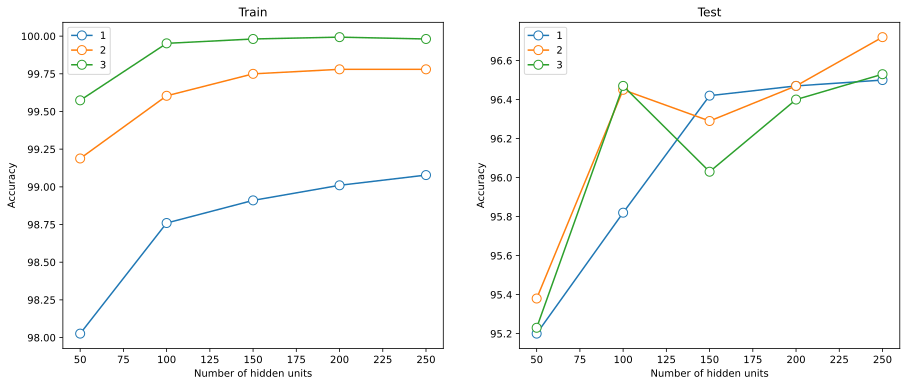

In [15]:
# Run the model and show the results!

### run the experiment! (note: takes ~30 mins)

# define the model parameters
numlayers = range(1,4)           # number of hidden layers
numunits  = np.arange(50,251,50) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((2,len(numunits),len(numlayers)))

# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create and train a fresh model
    trainAcc,testAcc,losses,net = funtion2trainTheModel(numunits[unitidx],numlayers[layeridx])

    # store the results (average of final 5 epochs)
    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    # print a friendly status message
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}') 


# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()

# Code Challenge - Convolution - Choosing parameters

In [16]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

## Sample problem

### Convolve an image of size 1x256x256 to produce a 1x252x84 result

In [17]:
# parameters
inChans  = 1 # RGB
imsize   = [256,256]
outChans = 1
krnSize  = 7 # should be an odd number
stride   = (1,3)
padding  = 1

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [  1 252  84]
Empirical size: [252, 84]


### 1) Convolve an image of size 3x64x64 to produce a 10x28x28 result

In [66]:
# parameters
inChans  = 3
imsize   = [64, 64]
outChans = 10
krnSize  = 9
stride   = (2,2)
padding  = 0

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [10 28 28]
Empirical size: [10, 28, 28]


### 2) Convolve an image of size 3x196x96 to produce a 5x66x49 result

In [71]:
# parameters
inChans  = 3
imsize   = [196, 96]
outChans = 5
krnSize  = 3
stride   = (3,2)
padding  = 2

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 5 66 49]
Empirical size: [5, 66, 49]


### 3) Convolve an image of size 1x32x32 to produce a 6x28x28 result

In [72]:
# parameters
inChans  = 1
imsize   = [32, 32]
outChans = 6
krnSize  = 5
stride   = (1,1)
padding  = 0

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 6 28 28]
Empirical size: [6, 28, 28]


### 4) Convolve an image of size 3x227x227 to produce a 96x55x55 result

In [85]:
# parameters
inChans  = 3
imsize   = [227, 227]
outChans = 96
krnSize  = 9
stride   = (4,4)
padding  = 0

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [96 55 55]
Empirical size: [96, 55, 55]


### 5) Convolve an image of size 3x224x224 to produce a 64x224x224 result

In [87]:
# parameters
inChans  = 3
imsize   = [224, 224]
outChans = 64
krnSize  = 3
stride   = (1,1)
padding  = 1

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 64 224 224]
Empirical size: [64, 224, 224]
